# Task 1 — Brent Oil Change Point Analysis (Foundation: Workflow + Data Understanding)

**Project:** Change Point Analysis and Statistical Modeling (Week 11)  
**Task:** Task 1 — Laying the Foundation for Analysis  

This notebook is a **reproducible driver** for the Task 1 pipeline. It documents the workflow from raw data to analysis-ready features, runs the modular scripts end-to-end, and validates the curated events registry used to contextualize potential structural breaks (without claiming causality).


## 1) Objective (Task 1)

Task 1 goals:
1. Define the data analysis workflow from **loading → cleaning → feature engineering → EDA → insight generation**.
2. Research and compile a structured **events registry** (≥10–15 events) relevant to oil prices.
3. State **assumptions and limitations**, including the difference between correlation in time and causal impact.
4. Determine **communication channels** for stakeholders.
5. Investigate time-series properties (trend, stationarity, volatility) and explain how these inform modeling choices.

**Key modeling decision:** perform change point analysis primarily on **log-returns** (typically stationary) rather than price levels (typically non-stationary).


## 2) Deliverables mapping (what Task 1 requires vs where it lives)

### Deliverable A — 1–2 page workflow document
- Location: `reports/interim/task1_workflow_plan.md`

### Deliverable B — Structured event dataset (≥10–15 events)
- Location: `data/raw/events.csv`
- Validation script: `scripts/04_validate_events.py`

### Deliverable C — Assumptions and limitations (including correlation vs causation)
- Location: `reports/interim/assumptions_limitations.md`

### Source register (recommended for auditability)
- Location: `data/raw/sources.md`


## 3) Planned analysis workflow (narrative)

### Step A — Data ingestion
- Input: raw Brent daily prices with columns `Date, Price` (stored under `data/raw/`).

### Step B — Data cleaning (quality + schema)
- Parse dates (expected format: `%d-%b-%y`, e.g., `20-May-87`).
- Coerce prices to numeric.
- Drop invalid rows (`date` or `price` missing).
- Enforce positive prices for log transforms (optional toggle in cleaning function).
- Handle duplicate dates using an explicit rule (`keep_last`, `keep_first`, `mean`, `median`, `drop`).
- Output: `data/interim/brent_prices_clean.csv`.

### Step C — Feature engineering
- Compute `log_price = log(price)`.
- Compute `log_return = log_price.diff()`.
- Output: `data/processed/brent_log_returns.csv`.

### Step D — Exploratory analysis & diagnostics
- Trend inspection on `price` / `log_price`.
- Stationarity tests: **ADF** and **KPSS** on `price`, `log_price`, `log_return`.
- Volatility patterns: rolling volatility of returns.
- Outputs: figures in `reports/figures/` and a stationarity summary CSV.

### Step E — Event registry compilation & validation
- Input: `data/raw/events.csv` containing 10–15 key events.
- Validate schema and date logic using `scripts/04_validate_events.py`.
- Use events to **contextualize** detected changes (not as causal proof).

### Step F — Insight generation (Task 1 level)
- Decide which series is appropriate for change point analysis (levels vs returns).
- Summarize volatility clustering and regime-like behavior visually.
- Prepare stakeholder-ready communication artifacts.


## 4) Data description

### 4.1 Price data
- Expected schema: `Date, Price`
- Frequency: daily
- Cleaned output schema: `date, price` (sorted ascending)

### 4.2 Events registry
- File: `data/raw/events.csv`
- Required columns (as advertised by `scripts/04_validate_events.py`):
  - `event_id`, `event_name`, `start_date`, `end_date`, `event_type`, `description`, `region`, `source`

### 4.3 Event validation rules
- `event_id` must be unique
- `start_date` must parse
- `end_date` may be blank for ongoing events
- if `end_date` exists, `start_date <= end_date`

Full reference details (beyond short source strings in the CSV) should be maintained in `data/raw/sources.md`.


## 5) Assumptions, limitations, and correlation vs causation

Task 1 can identify **statistical structure** (e.g., non-stationarity in levels, volatility clustering, candidate break dates) and **temporal alignment** with events. It cannot establish causality.

Assumptions and limitations are documented in:  
- `reports/interim/assumptions_limitations.md`

### Correlation vs causation (required discussion)
Even if an inferred change point lines up with an event window, that alignment is **correlational**.

Reasons alignment may not imply causality:
- anticipatory market pricing (information arrives before the recorded event date)
- confounding macro variables (demand shocks, USD moves, inventories, interest rates)
- contemporaneous events not included in the registry
- model and measurement uncertainty in change point location

Causal claims require separate identification strategies (e.g., instruments, natural experiments, synthetic controls, structural models).


## 6) Communication channels and formats

Main channels/formats for stakeholders:
- **1–2 page written brief**: key findings, regimes, break dates (with uncertainty)
- **Slide deck**: annotated timelines, regime plots, interpretation guidance
- **Figure pack**: PNGs in `reports/figures/` for quick review
- **Technical appendix**: stationarity tests, data handling rules, assumptions/limitations

Suggested messaging:
- "We detect statistically distinct regimes in oil-market volatility." 
- "Events support interpretation of *when/why* regimes may shift, but do not prove causation." 
- "Outputs support risk monitoring, stress testing, and scenario planning."


## 7) Understanding the model and the data (conceptual)

### 7.1 Time-series properties to analyze
- **Trend analysis**: price levels often trend and have persistent shocks.
- **Stationarity**: many statistical models require (or work best with) stationary inputs.
- **Volatility patterns**: commodity returns frequently show volatility clustering and heavy tails.

### 7.2 Why log-returns
Define:
$$
 r_t = \log(p_t) - \log(p_{t-1})
$$

Log-returns often:
- reduce trend/unit-root behavior
- have more stable variance
- are closer to stationarity than levels

### 7.3 Stationarity tests
- **ADF (Augmented Dickey-Fuller)**: H0 = unit root (non-stationary). Small p-value → reject H0.
- **KPSS**: H0 = stationary. Small p-value → reject stationarity.

Using both is more robust than using either alone.


## 8) Change point models (purpose + expected outputs)

### Purpose
Change point models detect **structural breaks** where the data-generating process changes. In oil markets, this can reflect:
- demand/supply shocks
- policy shifts (OPEC decisions)
- geopolitical disruptions
- macro regime changes

### What they output (expected)
- Estimated break date(s) (point estimates and/or posterior distributions)
- Regime parameters before/after breaks (e.g., mean return \u03bc, volatility \u03c3)
- Uncertainty around break timing and parameter shifts

### Limitations
- Break dates are uncertain and can be blurred by overlapping events.
- Results depend on model assumptions (likelihood choice, priors, number of breaks).
- Detecting a break does not identify its cause.


## 9) Pipeline execution (scripts 01 → 04)

This section runs the Task 1 scripts sequentially. Scripts are designed to be **idempotent** (safe to re-run).

Expected scripts:
1. `scripts/01_clean_prices.py`
2. `scripts/02_make_returns.py`
3. `scripts/03_run_task1_eda.py`
4. `scripts/04_validate_events.py`


In [22]:
from pathlib import Path
import subprocess

REPO_ROOT = Path(r"D:\Python\Week11\Change-Point-Analysis-and-Statistical-Modeling")
PYTHON_EXE = REPO_ROOT / "Menv" / "Scripts" / "python.exe"

assert REPO_ROOT.exists(), f"Repo root not found: {REPO_ROOT}"
assert PYTHON_EXE.exists(), f"Python exe not found: {PYTHON_EXE}"

REPO_ROOT, PYTHON_EXE

(WindowsPath('D:/Python/Week11/Change-Point-Analysis-and-Statistical-Modeling'),
 WindowsPath('D:/Python/Week11/Change-Point-Analysis-and-Statistical-Modeling/Menv/Scripts/python.exe'))

In [23]:
def run(script_relpath: str) -> None:
    script_path = REPO_ROOT / script_relpath
    assert script_path.exists(), f"Missing script: {script_path}"
    print(f"\n=== Running: {script_relpath} ===")
    result = subprocess.run(
        [str(PYTHON_EXE), str(script_path)],
        cwd=str(REPO_ROOT),
        capture_output=True,
        text=True,
        check=False,
    )
    print(result.stdout)
    if result.returncode != 0:
        print(result.stderr)
        raise RuntimeError(f"Script failed ({result.returncode}): {script_relpath}")

# Run Task 1 pipeline
run("scripts/01_clean_prices.py")
run("scripts/02_make_returns.py")
run("scripts/03_run_task1_eda.py")
run("scripts/04_validate_events.py")


=== Running: scripts/01_clean_prices.py ===
[OK] Cleaned data written to: D:\Python\Week11\Change-Point-Analysis-and-Statistical-Modeling\data\interim\brent_prices_clean.csv
        date  price
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63
Rows: 8,360 | Range: 1987-05-20 00:00:00 â†’ 2020-04-21 00:00:00


=== Running: scripts/02_make_returns.py ===
[OK] Processed data written to: D:\Python\Week11\Change-Point-Analysis-and-Statistical-Modeling\data\processed\brent_log_returns.csv
        date  price  log_price  log_return
0 1987-05-20  18.63   2.924773         NaN
1 1987-05-21  18.45   2.915064   -0.009709
2 1987-05-22  18.55   2.920470    0.005405
3 1987-05-25  18.60   2.923162    0.002692
4 1987-05-26  18.63   2.924773    0.001612
5 1987-05-27  18.60   2.923162   -0.001612
6 1987-05-28  18.60   2.923162    0.000000
7 1987-05-29  18.58   2.922086   -0.001076
8 1987-06-01  18.65   2.925846    0.003760
9 1987-06-02  18.68   2.927453 

## 10) Inspect outputs (data, tables, figures)

This section loads expected artifacts written by the scripts.


In [24]:
import pandas as pd
from IPython.display import Image, display

paths = {
    "clean_prices": REPO_ROOT / "data" / "interim" / "brent_prices_clean.csv",
    "log_returns": REPO_ROOT / "data" / "processed" / "brent_log_returns.csv",
    "stationarity": REPO_ROOT / "reports" / "figures" / "stationarity_tests_task1.csv",
    "events": REPO_ROOT / "data" / "raw" / "events.csv",
    "workflow_plan": REPO_ROOT / "reports" / "interim" / "task1_workflow_plan.md",
    "assumptions": REPO_ROOT / "reports" / "interim" / "assumptions_limitations.md",
    "sources": REPO_ROOT / "data" / "raw" / "sources.md",
}

loaded = {}
for k, p in paths.items():
    if p.exists():
        print(f"[OK] Found {k}: {p}")
        if p.suffix.lower() == ".csv":
            loaded[k] = pd.read_csv(p)
    else:
        print(f"[WARN] Missing {k}: {p}")

loaded.keys()

[OK] Found clean_prices: D:\Python\Week11\Change-Point-Analysis-and-Statistical-Modeling\data\interim\brent_prices_clean.csv
[OK] Found log_returns: D:\Python\Week11\Change-Point-Analysis-and-Statistical-Modeling\data\processed\brent_log_returns.csv
[OK] Found stationarity: D:\Python\Week11\Change-Point-Analysis-and-Statistical-Modeling\reports\figures\stationarity_tests_task1.csv
[OK] Found events: D:\Python\Week11\Change-Point-Analysis-and-Statistical-Modeling\data\raw\events.csv
[OK] Found workflow_plan: D:\Python\Week11\Change-Point-Analysis-and-Statistical-Modeling\reports\interim\task1_workflow_plan.md
[OK] Found assumptions: D:\Python\Week11\Change-Point-Analysis-and-Statistical-Modeling\reports\interim\assumptions_limitations.md
[OK] Found sources: D:\Python\Week11\Change-Point-Analysis-and-Statistical-Modeling\data\raw\sources.md


dict_keys(['clean_prices', 'log_returns', 'stationarity', 'events'])

In [25]:
# Preview key datasets / summary tables
if "clean_prices" in loaded:
    display(loaded["clean_prices"].head())
    display(loaded["clean_prices"].tail())

if "log_returns" in loaded:
    display(loaded["log_returns"].head(10))
    for col in ["log_price", "log_return"]:
        if col in loaded["log_returns"].columns:
            print(col, "missing:", int(loaded["log_returns"][col].isna().sum()))

if "stationarity" in loaded:
    display(loaded["stationarity"])

,date,price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


,date,price
8355,2020-04-15,19.80
8356,2020-04-16,18.69
8357,2020-04-17,19.75
8358,2020-04-20,17.36
8359,2020-04-21,9.12


,date,price,log_price,log_return
0,1987-05-20,18.63,2.924773,NaN
1,1987-05-21,18.45,2.915064,-0.009709
2,1987-05-22,18.55,2.920470,0.005405
3,1987-05-25,18.60,2.923162,0.002692
4,1987-05-26,18.63,2.924773,0.001612
5,1987-05-27,18.60,2.923162,-0.001612
6,1987-05-28,18.60,2.923162,0.000000
7,1987-05-29,18.58,2.922086,-0.001076
8,1987-06-01,18.65,2.925846,0.003760
9,1987-06-02,18.68,2.927453,0.001607


log_price missing: 0
log_return missing: 1


,column,test,statistic,p_value,n_lags,n_obs,note
0,price,ADF,-2.018653,2.784547e-01,34,8325,NaN
1,price,KPSS(c),9.623271,1.000000e-02,55,8360,NaN
2,price,KPSS(ct),1.105902,1.000000e-02,55,8360,NaN
3,log_price,ADF,-1.560254,5.035221e-01,30,8329,NaN
4,log_price,KPSS(c),11.552512,1.000000e-02,55,8360,NaN
5,log_price,KPSS(ct),1.275462,1.000000e-02,55,8360,NaN
6,log_return,ADF,-12.603089,1.719111e-23,29,8329,NaN
7,log_return,KPSS(c),0.342525,1.000000e-01,4,8359,NaN
8,log_return,KPSS(ct),0.175587,2.534448e-02,4,8359,NaN


Figure dir: D:\Python\Week11\Change-Point-Analysis-and-Statistical-Modeling\reports\figures
Found 7 PNG(s)
 - 01_price_and_log_price.png
 - 02_log_returns.png
 - 03_rolling_volatility_30d.png
 - log_returns_series.png
 - price_series.png
 - rolling_volatility.png
 - stationarity_tests_table.png


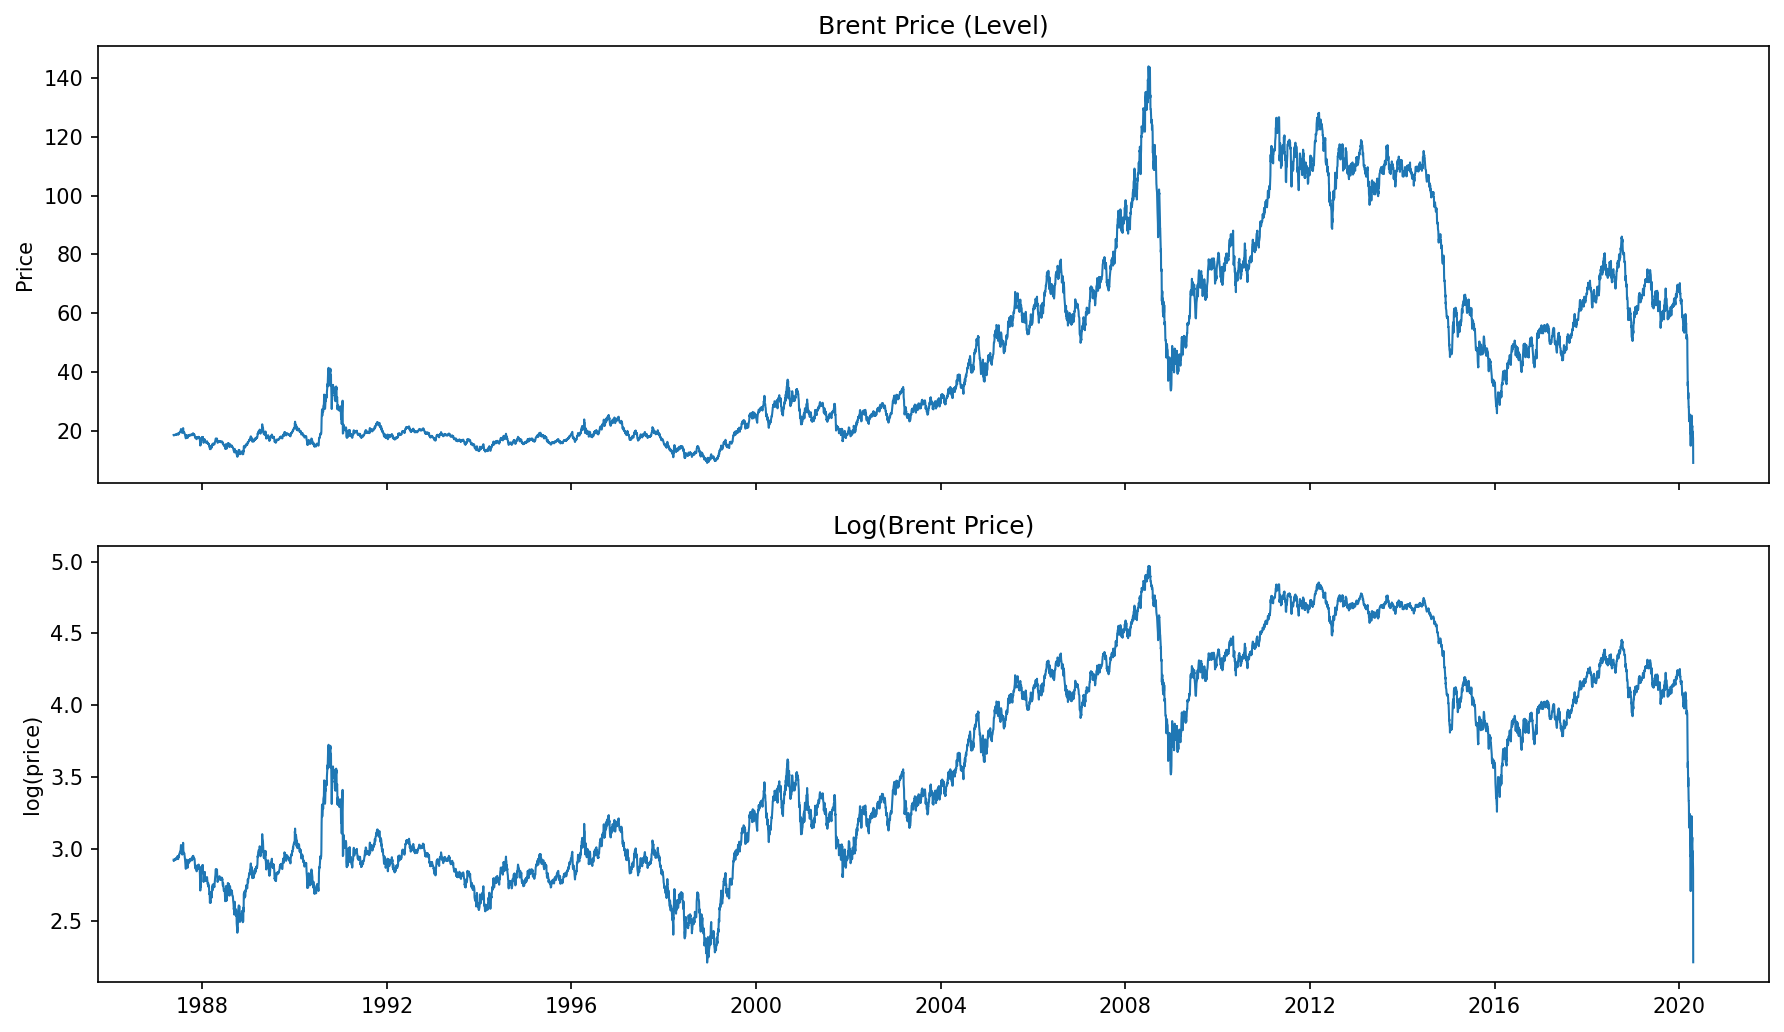

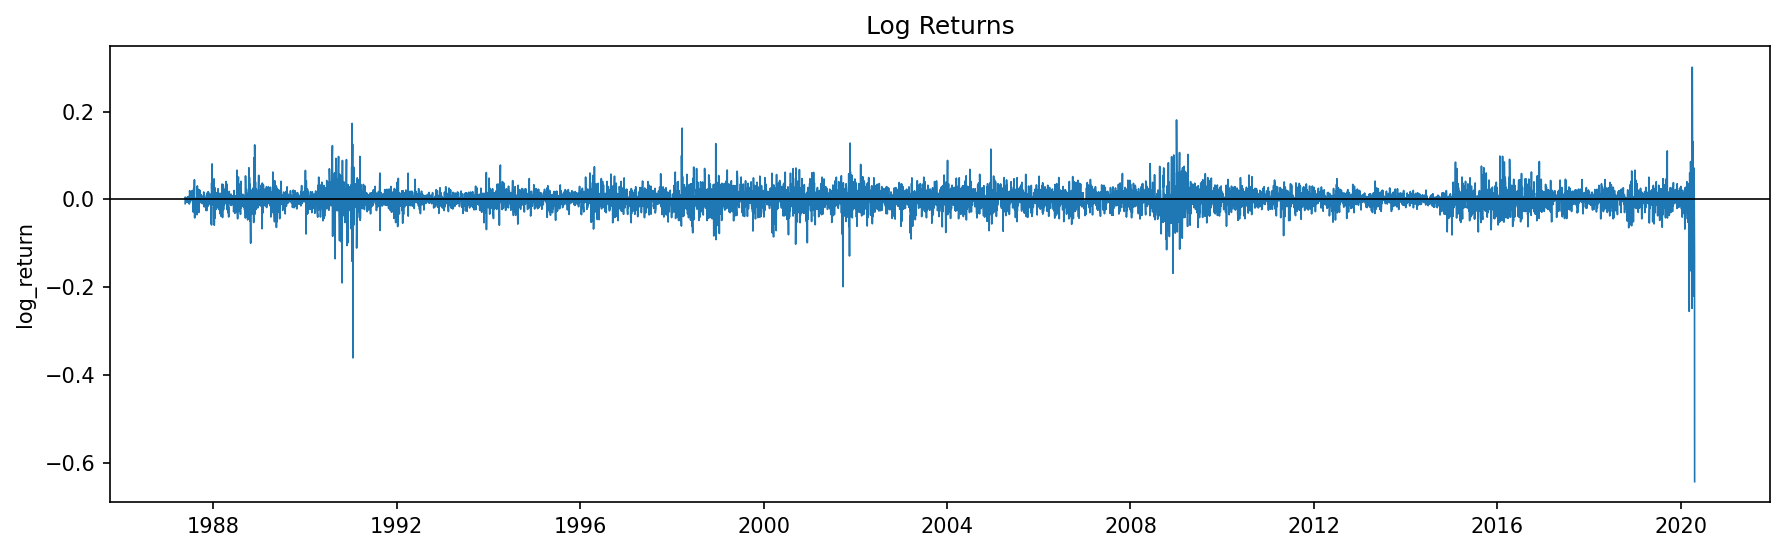

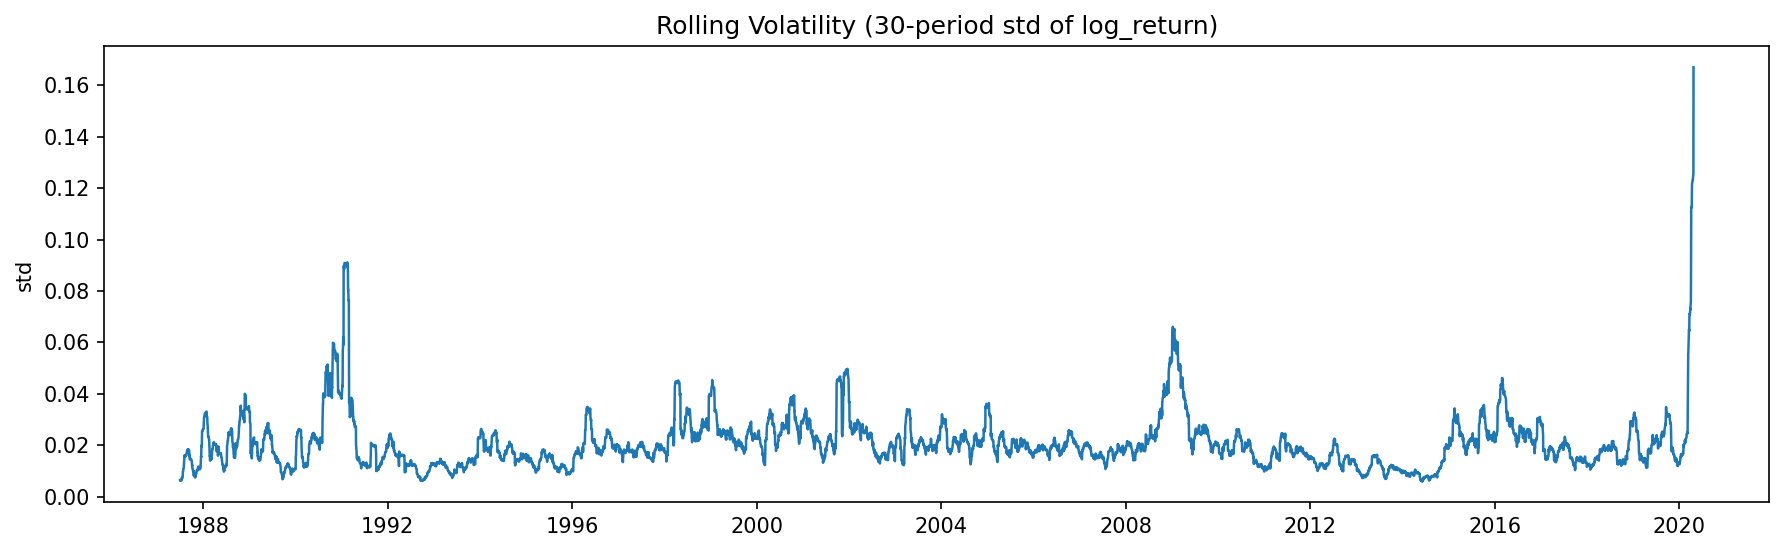

In [26]:
# Inspect and display a few figures if present
fig_dir = REPO_ROOT / "reports" / "figures"
print("Figure dir:", fig_dir)

if fig_dir.exists():
    figs = sorted(fig_dir.glob("*.png"))
    print(f"Found {len(figs)} PNG(s)")
    for p in figs[:12]:
        print(" -", p.name)
    for p in figs[:4]:
        display(Image(filename=str(p)))
else:
    print("[WARN] reports/figures not found")

Figure dir: D:\Python\Week11\Change-Point-Analysis-and-Statistical-Modeling\reports\figures
Target: D:\Python\Week11\Change-Point-Analysis-and-Statistical-Modeling\reports\figures\stationarity_tests_table.png
Exists: True
Size (bytes): 92509


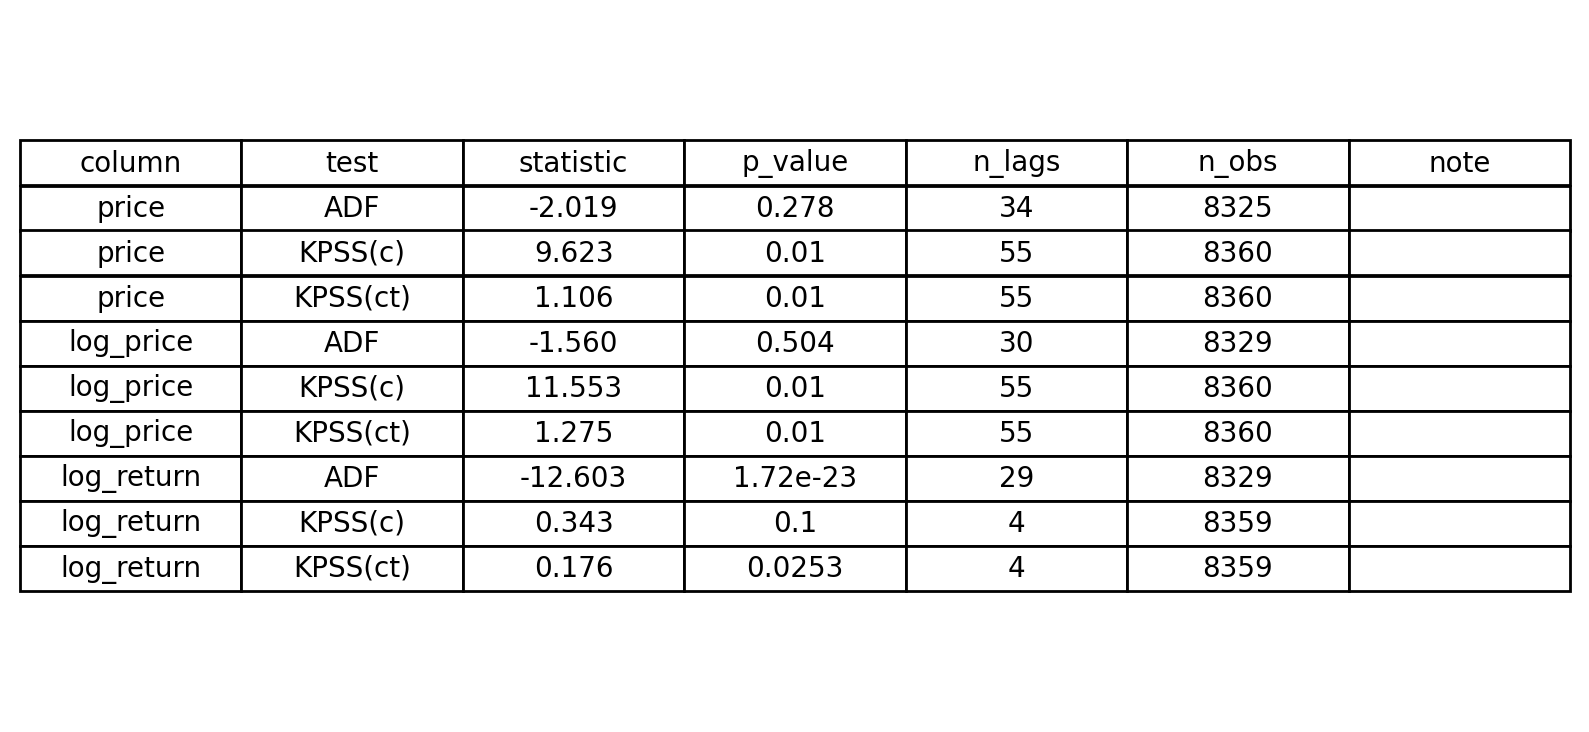

In [27]:
from pathlib import Path
from IPython.display import display, Image as IPyImage
import os

fig_dir = REPO_ROOT / "reports" / "figures"
target = fig_dir / "stationarity_tests_table.png"

print("Figure dir:", fig_dir)
print("Target:", target)
print("Exists:", target.exists())
if target.exists():
    print("Size (bytes):", target.stat().st_size)

    # display explicitly (most reliable)
    display(IPyImage(filename=str(target)))

    # also show a direct HTML <img> fallback (helps if Image() is finicky)
    display(
        __import__("IPython").display.HTML(
            f"<div>![image]({target.as_posix()})</div>"
        )
    )
else:
    print("[WARN] stationarity_tests_table.png not found")

## 11) Reproducibility notes

### Run from command line (PowerShell)
```powershell
pytest -q
& .\Menv\Scripts\python.exe .\scripts\01_clean_prices.py
& .\Menv\Scripts\python.exe .\scripts\02_make_returns.py
& .\Menv\Scripts\python.exe .\scripts\03_run_task1_eda.py
& .\Menv\Scripts\python.exe .\scripts\04_validate_events.py
```

### Task 1 audit trail
- Workflow plan: `reports/interim/task1_workflow_plan.md`
- Assumptions/limitations: `reports/interim/assumptions_limitations.md`
- Sources: `data/raw/sources.md`

### Expected acceptance checks
- All tests pass (`pytest`).
- Cleaned dataset exists and has a sensible date range.
- Processed log-returns exist; first return is missing by construction.
- Stationarity table shows `log_return` is stationary (ADF rejects unit root; KPSS(c) does not reject stationarity).
- Events registry validates successfully and has ≥10–15 entries.
